# Explore the data

Explore the Ebola dataset and preprocess according to the study [rstb20160308](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5394646/pdf/rstb20160308.pdf).

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import json
import os

from matplotlib import pyplot as plt
%matplotlib inline

from lib.settings import DATA_DIR

Load the clean dataset

In [4]:
df_clean = pd.read_csv(os.path.join(DATA_DIR, 'ebola', 'rstb20160308_si_001_cleaned.csv'),
                       parse_dates=['infection_date'], 
                       infer_datetime_format=True)
print(df_clean.shape)
df_clean.head()

(27531, 3)


,district,infection_date,infection_timestamp
0,WESTERN,2013-12-26,0.0
1,PUJEHUN,2013-12-26,0.0
2,TONKOLILI,2014-01-01,6.0
3,WESTERN,2014-01-01,6.0
4,GUECKEDOU,2014-01-01,6.0


---

## Plot the number infected over time

For the recoveries, we use for each infection the average rate plus/minus standard deviation from the literature.

In [9]:
rec_avg = 11.4 # in days
rec_std = 5.5 # in days

In [10]:
df_clean['recovery_timestamp_mean'] = df_clean.infection_timestamp + rec_avg
df_clean['recovery_timestamp_min'] = df_clean.infection_timestamp + rec_avg - rec_std
df_clean['recovery_timestamp_max'] = df_clean.infection_timestamp + rec_avg + rec_std

In [12]:
df_clean.head()

,district,infection_date,infection_timestamp,recovery_timestamp_mean,recovery_timestamp_min,recovery_timestamp_max
0,WESTERN,2013-12-26,0.0,11.4,5.9,16.9
1,PUJEHUN,2013-12-26,0.0,11.4,5.9,16.9
2,TONKOLILI,2014-01-01,6.0,17.4,11.9,22.9
3,WESTERN,2014-01-01,6.0,17.4,11.9,22.9
4,GUECKEDOU,2014-01-01,6.0,17.4,11.9,22.9


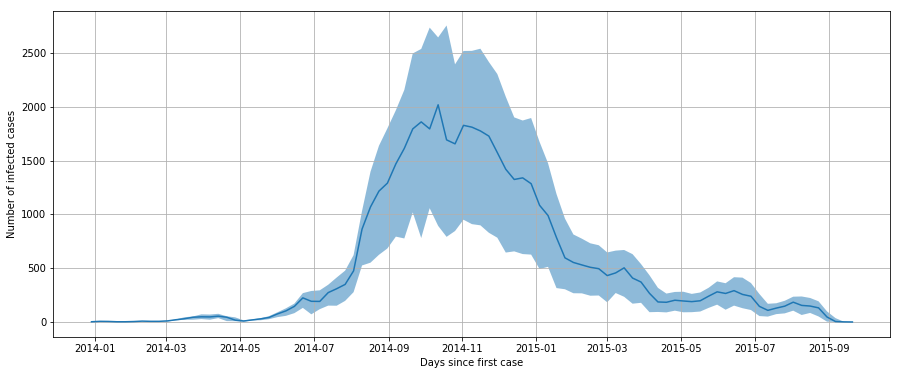

In [28]:
tspace = np.arange(min(df_clean.infection_timestamp),max(df_clean.infection_timestamp)+1, 7)[:-1]
dspace = pd.date_range(df_clean.infection_date.iloc[0], df_clean.infection_date.iloc[-1], freq='W')

y_min = np.zeros_like(tspace)
y_max = np.zeros_like(tspace)
y_mean = np.zeros_like(tspace)

for i, t in enumerate(tspace):
    y_min[i] = np.sum((df_clean.infection_timestamp <= t) & (df_clean.recovery_timestamp_min > t))
    y_max[i] = np.sum((df_clean.infection_timestamp <= t) & (df_clean.recovery_timestamp_max > t))
    y_mean[i] = np.sum((df_clean.infection_timestamp <= t) & (df_clean.recovery_timestamp_mean > t))


plt.figure(figsize=(15,6))
plt.grid()
plt.plot(dspace, y_mean)
plt.fill_between(dspace, y_min, y_max, label='avg $\pm$ std', alpha=0.5)

plt.xlabel('Days since first case')
plt.ylabel('Number of infected cases');

# plt.xlim('2014-05-11', '2014-07-20')
# plt.ylim(0, 300)

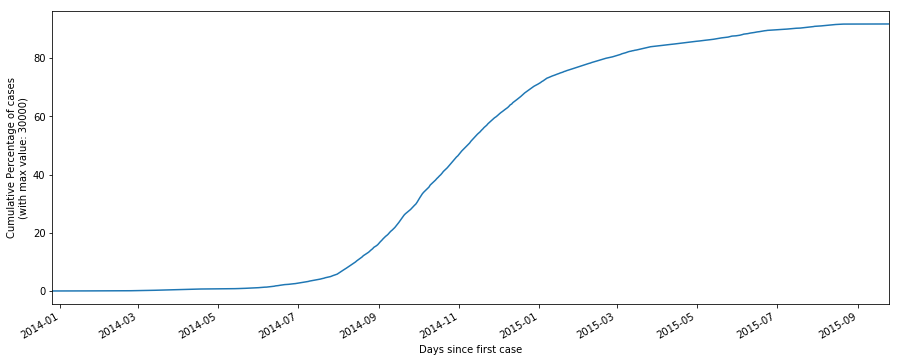

In [38]:
inf_cumsum = df_clean.groupby('infection_date')['infection_timestamp'].count().cumsum()

max_val = 30000
inf_cumsum = inf_cumsum / max_val * 100

plt.figure(figsize=(15,6))
inf_cumsum.plot()
plt.xlabel('Days since first case')
plt.ylabel(f'Cumulative Percentage of cases\n(with max value: {max_val})');

---

### Format into infection timeseries per district

In [80]:
df_ts = df_clean.groupby('district').infection_timestamp.apply(list)

In [81]:
df_ts

district
BEYLA               [233.0, 260.0, 266.0, 273.0, 279.0, 284.0, 284...
BO                  [176.0, 188.0, 190.0, 190.0, 191.0, 193.0, 194...
BOFFA               [127.0, 143.0, 144.0, 144.0, 145.0, 146.0, 147...
BOKE                [277.0, 496.0, 497.0, 497.0, 498.0, 513.0, 524...
BOMBALI             [162.0, 183.0, 194.0, 203.0, 205.0, 205.0, 207...
BOMI                [67.0, 175.0, 194.0, 196.0, 196.0, 198.0, 198....
BONG                [60.0, 82.0, 89.0, 93.0, 101.0, 105.0, 187.0, ...
BONTHE                     [203.0, 246.0, 288.0, 381.0, 482.0, 555.0]
CONAKRY             [69.0, 77.0, 78.0, 80.0, 84.0, 84.0, 85.0, 86....
COYAH               [235.0, 235.0, 245.0, 245.0, 254.0, 264.0, 268...
DABOLA              [84.0, 85.0, 93.0, 268.0, 283.0, 311.0, 328.0,...
DALABA              [254.0, 257.0, 258.0, 266.0, 266.0, 271.0, 279.0]
DUBREKA             [157.0, 230.0, 231.0, 235.0, 236.0, 236.0, 237...
FARANAH             [287.0, 289.0, 290.0, 308.0, 310.0, 310.0, 310...
FORECARIAH 